In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.18MB/s]


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
      # [batch_size, 1, 28 ,28]
        x = self.encoder(x)
        # [batch_size, 64, 1 ,1]
        x = self.decoder(x)
        # [batch_size, 1, 28 ,28]
        return x

In [ ]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [ ]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

/tmp/ipython-input-1883939916.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))


Epoch:1, Loss:0.0677
Epoch:2, Loss:0.0682
Epoch:3, Loss:0.0595
Epoch:4, Loss:0.0465
Epoch:5, Loss:0.0315
Epoch:6, Loss:0.0233
Epoch:7, Loss:0.0191
Epoch:8, Loss:0.0175
Epoch:9, Loss:0.0162
Epoch:10, Loss:0.0126
Epoch:11, Loss:0.0100
Epoch:12, Loss:0.0101
Epoch:13, Loss:0.0114
Epoch:14, Loss:0.0093
Epoch:15, Loss:0.0082
Epoch:16, Loss:0.0086
Epoch:17, Loss:0.0080
Epoch:18, Loss:0.0073
Epoch:19, Loss:0.0069
Epoch:20, Loss:0.0069


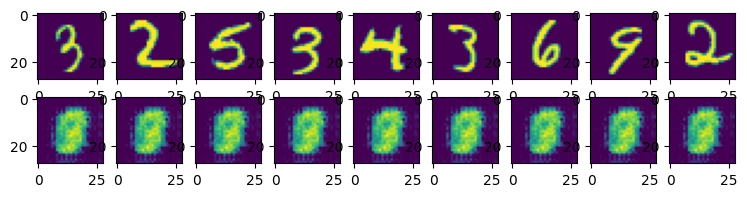

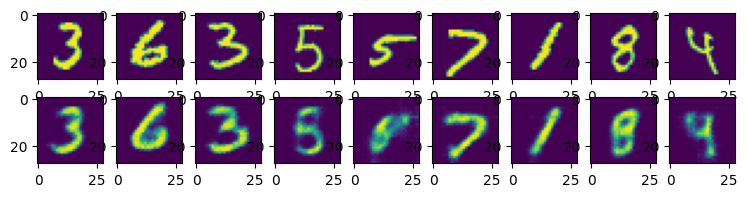

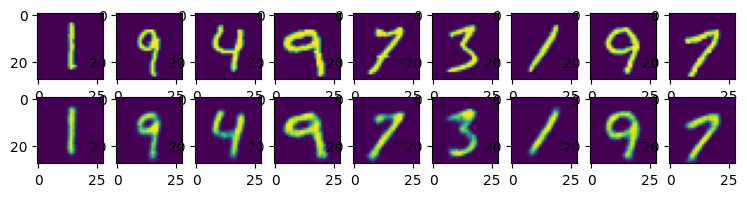

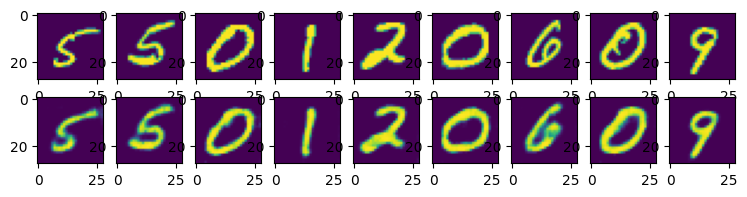

In [ ]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

# Denoising Autoencoder

Epoch 1/10, Loss: 0.0682
Epoch 2/10, Loss: 0.0698
Epoch 3/10, Loss: 0.0635
Epoch 4/10, Loss: 0.0609
Epoch 5/10, Loss: 0.0562
Epoch 6/10, Loss: 0.0439
Epoch 7/10, Loss: 0.0353
Epoch 8/10, Loss: 0.0330
Epoch 9/10, Loss: 0.0300
Epoch 10/10, Loss: 0.0220


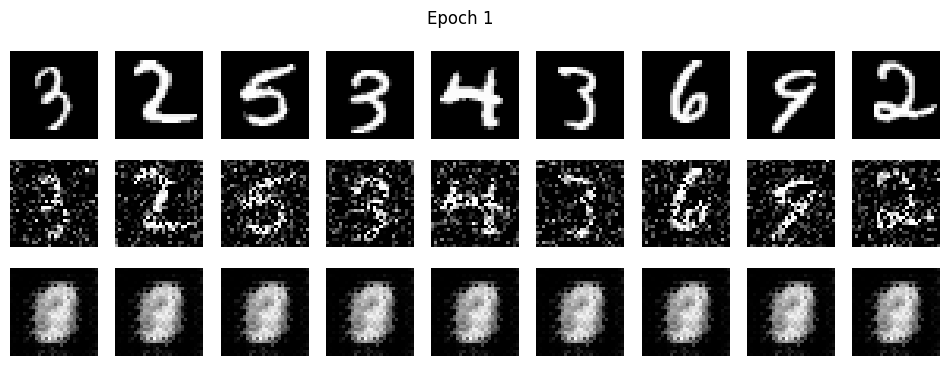

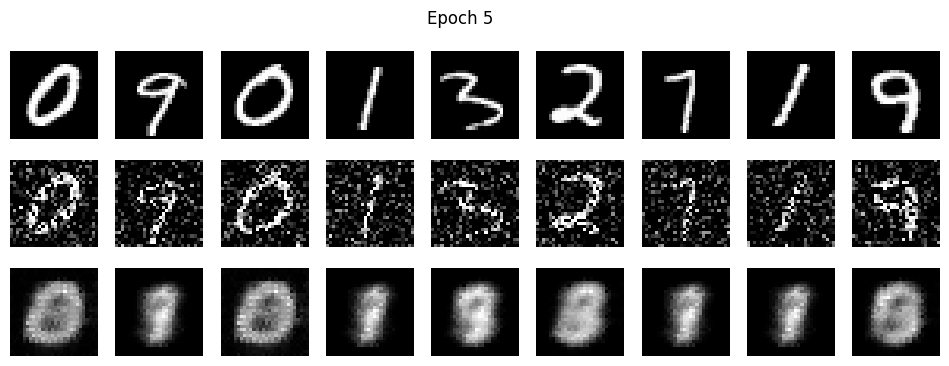

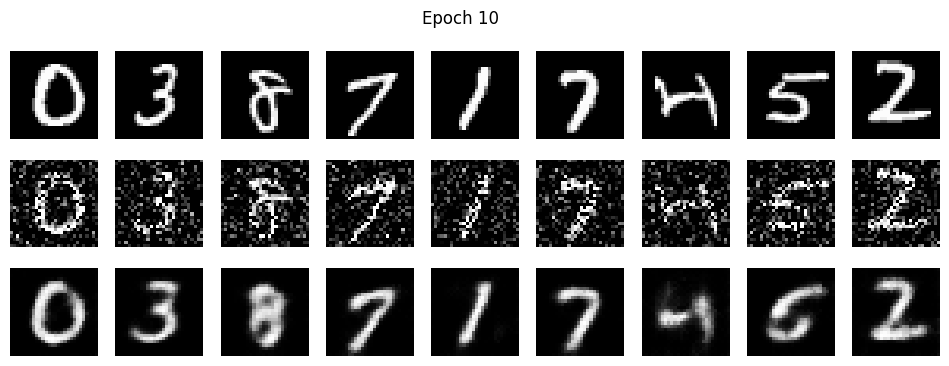

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# ===== 1️⃣ Dataset: MNIST + ToTensor =====
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

# ===== 2️⃣ Hàm thêm nhiễu Gaussian + Masking =====
def add_noise(imgs, sigma=0.3, mask_ratio=0.3):
    # Gaussian noise
    noisy = imgs + sigma * torch.randn_like(imgs)
    # Masking noise
    mask = (torch.rand_like(imgs) > mask_ratio).float()
    noisy = noisy * mask
    # Giới hạn lại trong [0,1]
    return torch.clamp(noisy, 0., 1.)

# ===== 3️⃣ Model: Denoising Autoencoder =====
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# ===== 4️⃣ Train loop =====
def train(model, num_epochs=10, batch_size=64, lr=1e-3, sigma=0.3, mask_ratio=0.3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    outputs = []

    for epoch in range(num_epochs):
        for img, _ in train_loader:
            noisy_img = add_noise(img, sigma, mask_ratio)   # ⚡️ Thêm nhiễu vào input
            recon = model(noisy_img)                        # Input là ảnh nhiễu
            loss = criterion(recon, img)                    # So sánh với ảnh gốc (clean)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
        outputs.append((epoch, img, noisy_img, recon))
    return outputs

# ===== 5️⃣ Run training =====
model = DenoisingAutoencoder()
outputs = train(model, num_epochs=10)

# ===== 6️⃣ Visualization =====
for k in [0, 4, 9]:  # visualize a few epochs
    plt.figure(figsize=(12, 4))
    clean = outputs[k][1].detach().numpy()
    noisy = outputs[k][2].detach().numpy()
    recon = outputs[k][3].detach().numpy()
    for i in range(9):
        # clean
        plt.subplot(3, 9, i+1)
        plt.imshow(clean[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Clean")

        # noisy
        plt.subplot(3, 9, 9+i+1)
        plt.imshow(noisy[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Noisy")

        # reconstructed
        plt.subplot(3, 9, 18+i+1)
        plt.imshow(recon[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel("Reconstructed")

    plt.suptitle(f"Epoch {outputs[k][0]+1}")
    plt.show()


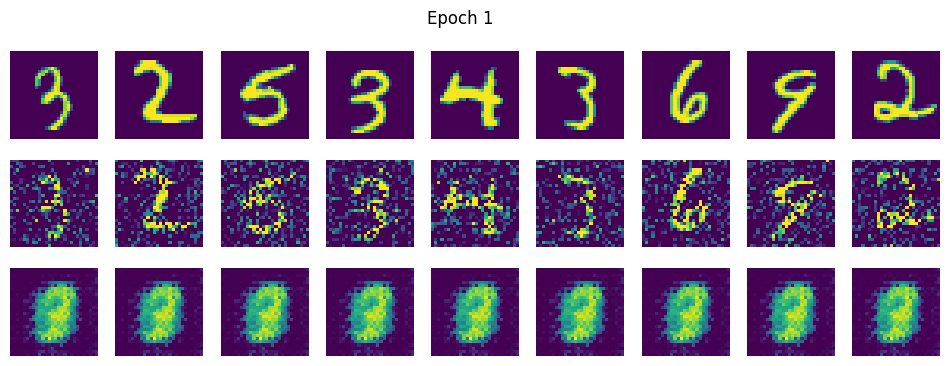

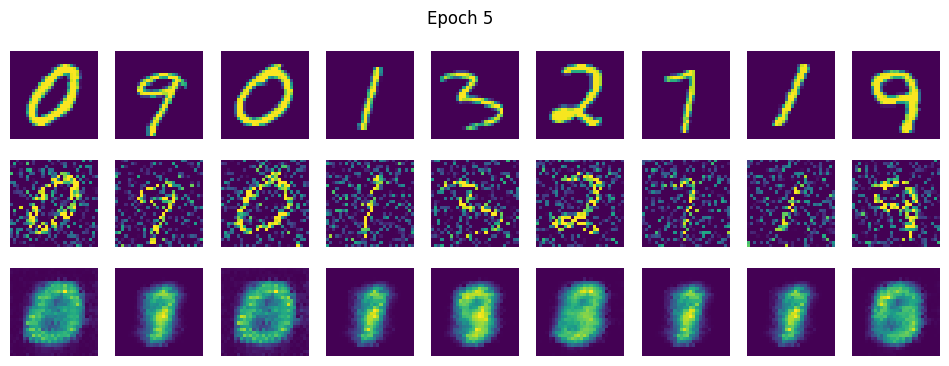

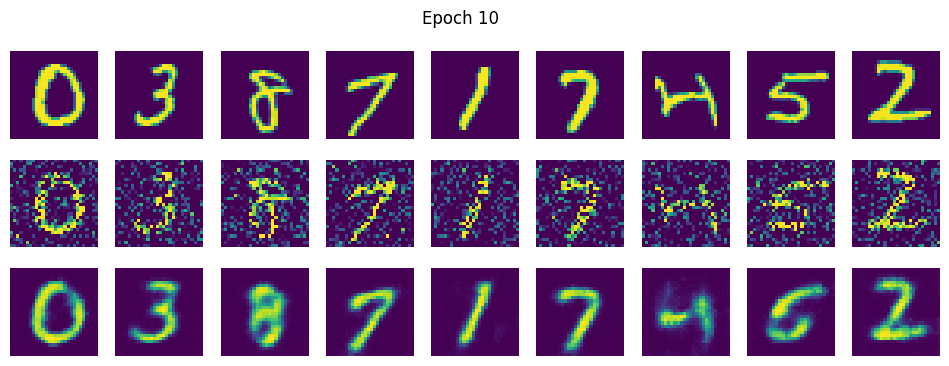

In [ ]:
for k in [0, 4, 9]:  # visualize a few epochs
    plt.figure(figsize=(12, 4))
    clean = outputs[k][1].detach().numpy()
    noisy = outputs[k][2].detach().numpy()
    recon = outputs[k][3].detach().numpy()
    for i in range(9):
        # clean
        plt.subplot(3, 9, i+1)
        plt.imshow(clean[i][0])
        plt.axis('off')
        if i == 0: plt.ylabel("Clean")

        # noisy
        plt.subplot(3, 9, 9+i+1)
        plt.imshow(noisy[i][0])
        plt.axis('off')
        if i == 0: plt.ylabel("Noisy")

        # reconstructed
        plt.subplot(3, 9, 18+i+1)
        plt.imshow(recon[i][0])
        plt.axis('off')
        if i == 0: plt.ylabel("Reconstructed")

    plt.suptitle(f"Epoch {outputs[k][0]+1}")
    plt.show()

# Sparse Autoencoder

Epoch 1/10, Loss: 0.222106
Epoch 2/10, Loss: 0.079407
Epoch 3/10, Loss: 0.070123
Epoch 4/10, Loss: 0.067432
Epoch 5/10, Loss: 0.063446
Epoch 6/10, Loss: 0.052880
Epoch 7/10, Loss: 0.044502
Epoch 8/10, Loss: 0.035545
Epoch 9/10, Loss: 0.029201
Epoch 10/10, Loss: 0.024597


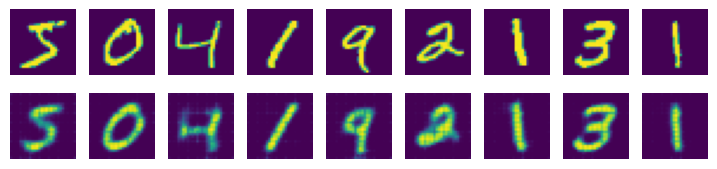

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# ====== 1. Dataset ======
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]


# ====== 2. Model ======
class SparseAutoencoder(nn.Module):
    def __init__(self, rho=0.05, beta=1e-3):
        super().__init__()
        self.rho = rho          # target sparsity
        self.beta = beta        # sparsity penalty weight

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.Sigmoid()  # dùng sigmoid để giá trị kích hoạt ∈ [0,1]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

    def kl_divergence(self, rho_hat):
        """Tính KL divergence giữa rho (mục tiêu) và rho_hat (trung bình thực tế)."""
        rho = self.rho
        return torch.sum(
            rho * torch.log(rho / (rho_hat + 1e-10)) +
            (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + 1e-10))
        )

# ====== 3. Train function ======
def train(model, num_epochs=10, batch_size=64, lr=1e-3):
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for imgs, _ in train_loader:
            recons, activations = model(imgs)

            # Reconstruction loss
            mse_loss = criterion(recons, imgs)

            # Sparsity loss: tính trung bình kích hoạt (trên batch)
            rho_hat = torch.mean(activations, dim=(0, 2, 3))  # trung bình trên batch và spatial
            sparsity_loss = model.kl_divergence(rho_hat)

            # Tổng loss
            loss = mse_loss + model.beta * sparsity_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")

# ====== 4. Train model ======
model = SparseAutoencoder(rho=0.05, beta=3e-3)
train(model, num_epochs=10)

# ====== 5. Hiển thị kết quả ======
def show_reconstruction(model, data, n=9):
    model.eval()
    imgs, _ = next(iter(torch.utils.data.DataLoader(data, batch_size=n)))
    recons, _ = model(imgs)

    imgs = imgs.detach().numpy()
    recons = recons.detach().numpy()

    plt.figure(figsize=(9, 2))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i][0])
        plt.axis('off')
        plt.subplot(2, n, n+i+1)
        plt.imshow(recons[i][0])
        plt.axis('off')
    plt.show()

show_reconstruction(model, mnist_data)


# k-Sparse Autoencoder



Epoch [1/10]  Loss: 0.1145
Epoch [2/10]  Loss: 0.0687
Epoch [3/10]  Loss: 0.0667
Epoch [4/10]  Loss: 0.0616
Epoch [5/10]  Loss: 0.0527
Epoch [6/10]  Loss: 0.0412
Epoch [7/10]  Loss: 0.0331
Epoch [8/10]  Loss: 0.0285
Epoch [9/10]  Loss: 0.0254
Epoch [10/10]  Loss: 0.0232


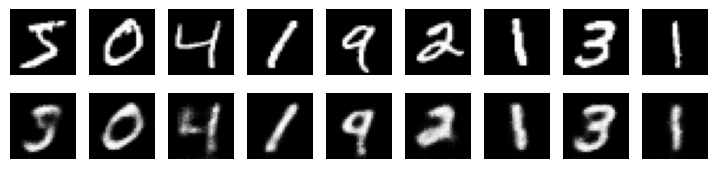

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== Dataset MNIST =====
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

# ===== k-Sparse Autoencoder =====
class KSparseAutoencoder(nn.Module):
    def __init__(self, k=10):
        super().__init__()
        self.k = k  # số lượng nơ-ron giữ lại
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # (1,28,28) -> (16,14,14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (16,14,14) -> (32,7,7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                        # (32,7,7) -> (64,1,1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def sparsify(self, z):
        """
        Giữ lại k phần tử lớn nhất theo giá trị tuyệt đối trong z, còn lại = 0
        z shape: (batch, channels, 1, 1)
        """
        z_flat = z.view(z.size(0), -1)  # (batch, 64)
        # Tìm top-k theo giá trị tuyệt đối
        _, idx = torch.topk(torch.abs(z_flat), self.k, dim=1)
        mask = torch.zeros_like(z_flat)
        mask.scatter_(1, idx, 1.0)
        z_sparse = z_flat * mask
        return z_sparse.view_as(z)

    def forward(self, x):
        z = self.encoder(x)
        z_sparse = self.sparsify(z)
        x_recon = self.decoder(z_sparse)
        return x_recon


# ===== Training loop =====
def train(model, num_epochs=10, batch_size=64, lr=1e-3):
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for img, _ in train_loader:
            recon = model(img)
            loss = criterion(recon, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {total_loss/len(train_loader):.4f}")

# ===== Train model =====
model = KSparseAutoencoder(k=10)
train(model, num_epochs=10)

# ===== Visualize reconstruction =====
def visualize(model, n=9):
    imgs = torch.stack([mnist_data[i][0] for i in range(n)])
    with torch.no_grad():
        recon = model(imgs)
    plt.figure(figsize=(9, 2))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i][0], cmap='gray')
        plt.axis('off')
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

visualize(model)


# Contractive Autoencoder

Epoch 1/5  Avg Loss: 0.116798  (recon 0.075536, cont 0.000000)
Epoch 2/5  Avg Loss: 0.067378  (recon 0.061119, cont 0.000000)
Epoch 3/5  Avg Loss: 0.061415  (recon 0.056579, cont 0.000000)
Epoch 4/5  Avg Loss: 0.047264  (recon 0.039069, cont 0.000000)
Epoch 5/5  Avg Loss: 0.032615  (recon 0.027433, cont 0.000000)


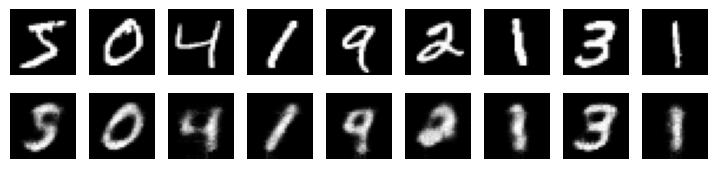

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== Dataset (lấy nhỏ để chạy nhanh) =====
transform = transforms.ToTensor()
mnist = datasets.MNIST('data', train=True, download=True, transform=transform)
mnist = list(mnist)[:4096]   # bạn có thể dùng đầy đủ dataset nếu có GPU

# ===== Model: giống cấu trúc bạn đưa =====
class ContractiveAutoencoder(nn.Module):
    def __init__(self, latent_channels=64):
        super().__init__()
        # Encoder -> output (batch, latent_channels, 1, 1)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> (16,14,14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> (32,7,7)
            nn.ReLU(),
            nn.Conv2d(32, latent_channels, 7)          # -> (latent_channels,1,1)
            # NOTE: không dùng activation ở cuối encoder ở đây; có thể thêm Sigmoid nếu muốn
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)             # (B, C, 1, 1)
        x_hat = self.decoder(z)
        return x_hat, z

# ===== Helper: compute contractive penalty (Jacobian Frobenius norm) =====
def contractive_penalty(x, z):
    B = x.size(0)
    x_flat = x.view(B, -1)
    z_flat = z.view(B, -1)

    total = 0.0
    for i in range(B):
        xi = x_flat[i:i+1]
        zi = z_flat[i]
        for j in range(zi.size(0)):
            grad_xj = torch.autograd.grad(zi[j], xi, retain_graph=True, create_graph=True, allow_unused=True)[0]
            if grad_xj is not None:
                total = total + grad_xj.pow(2).sum()
    return torch.tensor(total, device=x.device)


    return total  # scalar tensor

# ===== Training loop with contractive loss =====
def train_contractive(model, data, epochs=10, batch_size=64, lr=1e-3, lambda_contractive=1e-3, device='cpu'):
    model.to(device)
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=lr)
    recon_crit = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            # we need inputs require grad because we compute grad z wrt x
            imgs.requires_grad_(True)

            opt.zero_grad()
            recons, z = model(imgs)

            # reconstruction loss
            recon_loss = recon_crit(recons, imgs)

            # contractive penalty
            # compute jacobian Frobenius norm (sum over batch). may be slow.
            cont_pen = contractive_penalty(imgs, z)

            loss = recon_loss + lambda_contractive * cont_pen

            loss.backward()
            opt.step()

            # disable require_grad for imgs to avoid accumulating graph
            imgs.requires_grad_(False)

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}  Avg Loss: {epoch_loss/len(loader):.6f}  (recon {recon_loss.item():.6f}, cont {cont_pen.item():.6f})")

# ===== Run training (small example) =====
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ContractiveAutoencoder(latent_channels=64)
train_contractive(model, mnist, epochs=5, batch_size=64, lr=1e-3, lambda_contractive=1e-4, device=device)

# ===== Visualize reconstructions =====
def visualize_recon(model, data, n=9, device='cpu'):
    model.eval()
    imgs = torch.stack([data[i][0] for i in range(n)]).to(device)
    with torch.no_grad():
        recon, _ = model(imgs)
    imgs = imgs.cpu().numpy()
    recon = recon.cpu().numpy()
    plt.figure(figsize=(9,2))
    for i in range(n):
        plt.subplot(2, n, i+1); plt.imshow(imgs[i][0], cmap='gray'); plt.axis('off')
        plt.subplot(2, n, n+i+1); plt.imshow(recon[i][0], cmap='gray'); plt.axis('off')
    plt.show()

visualize_recon(model, mnist, n=9, device=device)


# VAE: Variational Autoencoder

Epoch 1/30 - Loss: 173.6062
Epoch 2/30 - Loss: 126.4839
Epoch 3/30 - Loss: 116.7982
Epoch 4/30 - Loss: 112.1769
Epoch 5/30 - Loss: 109.3496
Epoch 6/30 - Loss: 107.4514
Epoch 7/30 - Loss: 106.1241
Epoch 8/30 - Loss: 105.1518
Epoch 9/30 - Loss: 104.2664
Epoch 10/30 - Loss: 103.5843
Epoch 11/30 - Loss: 103.0950
Epoch 12/30 - Loss: 102.5270
Epoch 13/30 - Loss: 102.0857
Epoch 14/30 - Loss: 101.6859
Epoch 15/30 - Loss: 101.2892
Epoch 16/30 - Loss: 100.9746
Epoch 17/30 - Loss: 100.7234
Epoch 18/30 - Loss: 100.3823
Epoch 19/30 - Loss: 100.1235
Epoch 20/30 - Loss: 99.8458
Epoch 21/30 - Loss: 99.6118
Epoch 22/30 - Loss: 99.4216
Epoch 23/30 - Loss: 99.2133
Epoch 24/30 - Loss: 99.0277
Epoch 25/30 - Loss: 98.8906
Epoch 26/30 - Loss: 98.7456
Epoch 27/30 - Loss: 98.5534
Epoch 28/30 - Loss: 98.3930
Epoch 29/30 - Loss: 98.2477
Epoch 30/30 - Loss: 98.1825


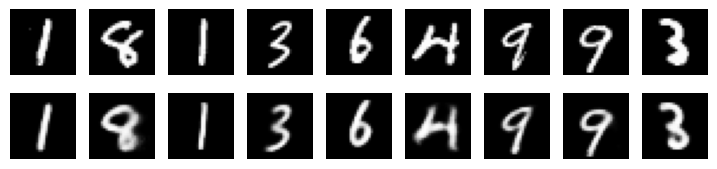

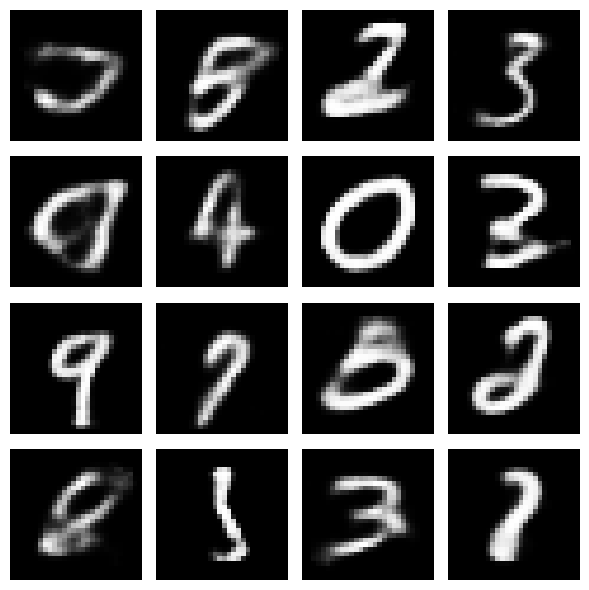

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ===== Dataset =====
transform = transforms.ToTensor()
mnist = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist, batch_size=128, shuffle=True)

# ===== VAE Model =====
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(256, latent_dim)
        self.logvar_layer = nn.Linear(256, latent_dim)

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z = μ + σ⊙ε

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# ===== Loss Function =====
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (recon_loss + kl_loss) / x.size(0), recon_loss / x.size(0), kl_loss / x.size(0)

# ===== Training Loop =====
def train_vae(model, dataloader, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()

            recons, mu, logvar = model(imgs)
            loss, recon_loss, kl_loss = vae_loss(recons, imgs, mu, logvar)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")
    return model

# ===== Visualization =====
def show_reconstructions(model, dataloader, device='cuda'):
    model.eval()
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)
    with torch.no_grad():
        recons, _, _ = model(imgs)
    imgs = imgs.cpu().numpy()
    recons = recons.cpu().numpy()
    plt.figure(figsize=(9,2))
    for i in range(9):
        plt.subplot(2,9,i+1)
        plt.imshow(imgs[i][0], cmap='gray')
        plt.axis('off')
        plt.subplot(2,9,9+i+1)
        plt.imshow(recons[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

# ===== Run Training =====
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VAE(latent_dim=20)
vae = train_vae(vae, train_loader, epochs=30, lr=1e-3, device=device)

show_reconstructions(vae, train_loader, device=device)

# ===== Generate New Images =====
def generate_samples(model, num_samples=16, device='cuda'):
    model.eval()
    with torch.no_grad():
        # 1️⃣ Sinh ngẫu nhiên vector latent z ~ N(0, I)
        z = torch.randn(num_samples, model.mu_layer.out_features).to(device)

        # 2️⃣ Dùng decoder để sinh ảnh
        samples = model.decode(z).cpu()

    # 3️⃣ Hiển thị ảnh
    plt.figure(figsize=(6,6))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(samples[i][0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ===== Run sampling =====
generate_samples(vae, num_samples=16, device=device)

